In [7]:
%%writefile dataset.py
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random

IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
DATA_DIR = 'VOCdevkit/VOC2012/'
IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'SegmentationClass')
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
N_CLASSES = 21
print(f"Using device: {DEVICE}")

class VOCDataset(Dataset):
    def __init__(self, image_dir, mask_dir, split_file, is_train=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.is_train = is_train

        with open(split_file, 'r') as f:
            filenames = [line.strip() for line in f]
        self.images = [os.path.join(image_dir, f"{name}.jpg") for name in filenames]
        self.masks = [os.path.join(mask_dir, f"{name}.png") for name in filenames]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx])

        if self.is_train:
            if random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        image_transform = transforms.Compose([
            transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = image_transform(image)
        
        mask = np.array(mask)
        mask[mask == 255] = 0
        pil_mask = Image.fromarray(mask.astype(np.uint8))
        resized_pil = pil_mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
        mask_tensor = torch.from_numpy(np.array(resized_pil)).long()
            
        return image, mask_tensor

train_split_file = os.path.join(DATA_DIR, 'ImageSets', 'Segmentation', 'train.txt')
val_split_file = os.path.join(DATA_DIR, 'ImageSets', 'Segmentation', 'val.txt')

train_dataset = VOCDataset(IMAGE_DIR, MASK_DIR, train_split_file, is_train=True)
val_dataset = VOCDataset(IMAGE_DIR, MASK_DIR, val_split_file, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Data pipelines created successfully for Pascal VOC 2012.")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

Overwriting dataset.py


In [9]:
%%writefile model.py
import torch
import torch.nn as nn
from torchinfo import summary

class DoubleConv(nn.Module):
    """(Convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class DownSample(nn.Module):
    """Downscaling with MaxPool then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class UpSample(nn.Module):
    """Upscaling then DoubleConv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = DownSample(64, 128)
        self.down2 = DownSample(128, 256)
        self.down3 = DownSample(256, 512)
        self.down4 = DownSample(512, 1024)
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)
        self.outc = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

model = UNet(in_channels=3, num_classes=21).to('cuda')
print("U-Net model created successfully using the article's modular structure.")
summary(model, input_size=(16, 3, 256, 256))

Overwriting model.py


Epoch 1/200 [Train]: 100%|██████████| 92/92 [01:11<00:00,  1.28it/s, loss=2.22]


Epoch 1 Summary: Avg Train Loss: 2.5951 | Validation Mean IoU: 0.0420
New best model saved with IoU: 0.0420


Epoch 2/200 [Train]: 100%|██████████| 92/92 [01:14<00:00,  1.24it/s, loss=2.11]


Epoch 2 Summary: Avg Train Loss: 2.2092 | Validation Mean IoU: 0.0436
New best model saved with IoU: 0.0436


Epoch 3/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=1.85]


Epoch 3 Summary: Avg Train Loss: 1.9817 | Validation Mean IoU: 0.0413


Epoch 4/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.71]


Epoch 4 Summary: Avg Train Loss: 1.7612 | Validation Mean IoU: 0.0414


Epoch 5/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=1.42]


Epoch 5 Summary: Avg Train Loss: 1.5923 | Validation Mean IoU: 0.0435


Epoch 6/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.28]


Epoch 6 Summary: Avg Train Loss: 1.4459 | Validation Mean IoU: 0.0440
New best model saved with IoU: 0.0440


Epoch 7/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.47]


Epoch 7 Summary: Avg Train Loss: 1.3349 | Validation Mean IoU: 0.0451
New best model saved with IoU: 0.0451


Epoch 8/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.04] 


Epoch 8 Summary: Avg Train Loss: 1.2558 | Validation Mean IoU: 0.0448


Epoch 9/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.29] 


Epoch 9 Summary: Avg Train Loss: 1.2088 | Validation Mean IoU: 0.0451
New best model saved with IoU: 0.0451


Epoch 10/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.2]  


Epoch 10 Summary: Avg Train Loss: 1.1649 | Validation Mean IoU: 0.0421


Epoch 11/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.01] 


Epoch 11 Summary: Avg Train Loss: 1.1332 | Validation Mean IoU: 0.0483
New best model saved with IoU: 0.0483


Epoch 12/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.45] 


Epoch 12 Summary: Avg Train Loss: 1.1055 | Validation Mean IoU: 0.0474


Epoch 13/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.04] 


Epoch 13 Summary: Avg Train Loss: 1.0870 | Validation Mean IoU: 0.0446


Epoch 14/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.27] 


Epoch 14 Summary: Avg Train Loss: 1.0677 | Validation Mean IoU: 0.0511
New best model saved with IoU: 0.0511


Epoch 15/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.855]


Epoch 15 Summary: Avg Train Loss: 1.0420 | Validation Mean IoU: 0.0528
New best model saved with IoU: 0.0528


Epoch 16/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.605]


Epoch 16 Summary: Avg Train Loss: 1.0168 | Validation Mean IoU: 0.0552
New best model saved with IoU: 0.0552


Epoch 17/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.23it/s, loss=0.822]


Epoch 17 Summary: Avg Train Loss: 0.9951 | Validation Mean IoU: 0.0566
New best model saved with IoU: 0.0566


Epoch 18/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.11] 


Epoch 18 Summary: Avg Train Loss: 0.9788 | Validation Mean IoU: 0.0623
New best model saved with IoU: 0.0623


Epoch 19/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.91] 


Epoch 19 Summary: Avg Train Loss: 0.9717 | Validation Mean IoU: 0.0669
New best model saved with IoU: 0.0669


Epoch 20/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.744]


Epoch 20 Summary: Avg Train Loss: 0.9474 | Validation Mean IoU: 0.0673
New best model saved with IoU: 0.0673


Epoch 21/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.01] 


Epoch 21 Summary: Avg Train Loss: 0.9314 | Validation Mean IoU: 0.0668


Epoch 22/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.2]  


Epoch 22 Summary: Avg Train Loss: 0.9237 | Validation Mean IoU: 0.0719
New best model saved with IoU: 0.0719


Epoch 23/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=1.3]  


Epoch 23 Summary: Avg Train Loss: 0.9121 | Validation Mean IoU: 0.0656


Epoch 24/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.03] 


Epoch 24 Summary: Avg Train Loss: 0.8995 | Validation Mean IoU: 0.0725
New best model saved with IoU: 0.0725


Epoch 25/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.2]  


Epoch 25 Summary: Avg Train Loss: 0.8884 | Validation Mean IoU: 0.0764
New best model saved with IoU: 0.0764


Epoch 26/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.515]


Epoch 26 Summary: Avg Train Loss: 0.8691 | Validation Mean IoU: 0.0745


Epoch 27/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.9]  


Epoch 27 Summary: Avg Train Loss: 0.8603 | Validation Mean IoU: 0.0865
New best model saved with IoU: 0.0865


Epoch 28/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.921]


Epoch 28 Summary: Avg Train Loss: 0.8432 | Validation Mean IoU: 0.0970
New best model saved with IoU: 0.0970


Epoch 29/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.709]


Epoch 29 Summary: Avg Train Loss: 0.8348 | Validation Mean IoU: 0.0991
New best model saved with IoU: 0.0991


Epoch 30/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.664]


Epoch 30 Summary: Avg Train Loss: 0.8305 | Validation Mean IoU: 0.0810


Epoch 31/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.698]


Epoch 31 Summary: Avg Train Loss: 0.8135 | Validation Mean IoU: 0.1010
New best model saved with IoU: 0.1010


Epoch 32/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.44] 


Epoch 32 Summary: Avg Train Loss: 0.8023 | Validation Mean IoU: 0.0941


Epoch 33/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=1.14] 


Epoch 33 Summary: Avg Train Loss: 0.7893 | Validation Mean IoU: 0.1074
New best model saved with IoU: 0.1074


Epoch 34/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=1.04] 


Epoch 34 Summary: Avg Train Loss: 0.7862 | Validation Mean IoU: 0.1071


Epoch 35/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.767]


Epoch 35 Summary: Avg Train Loss: 0.7689 | Validation Mean IoU: 0.0980


Epoch 36/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.626]


Epoch 36 Summary: Avg Train Loss: 0.7476 | Validation Mean IoU: 0.1212
New best model saved with IoU: 0.1212


Epoch 37/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.873]


Epoch 37 Summary: Avg Train Loss: 0.7392 | Validation Mean IoU: 0.0997


Epoch 38/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.672]


Epoch 38 Summary: Avg Train Loss: 0.7402 | Validation Mean IoU: 0.1227
New best model saved with IoU: 0.1227


Epoch 39/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.884]


Epoch 39 Summary: Avg Train Loss: 0.7078 | Validation Mean IoU: 0.1108


Epoch 40/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.62] 


Epoch 40 Summary: Avg Train Loss: 0.6937 | Validation Mean IoU: 0.1076


Epoch 41/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s, loss=0.794]


Epoch 41 Summary: Avg Train Loss: 0.6825 | Validation Mean IoU: 0.1240
New best model saved with IoU: 0.1240


Epoch 42/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.939]


Epoch 42 Summary: Avg Train Loss: 0.6698 | Validation Mean IoU: 0.1380
New best model saved with IoU: 0.1380


Epoch 43/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.713]


Epoch 43 Summary: Avg Train Loss: 0.6662 | Validation Mean IoU: 0.1258


Epoch 44/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=1.05] 


Epoch 44 Summary: Avg Train Loss: 0.6546 | Validation Mean IoU: 0.1238


Epoch 45/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=1.18] 


Epoch 45 Summary: Avg Train Loss: 0.6345 | Validation Mean IoU: 0.1355


Epoch 46/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.587]


Epoch 46 Summary: Avg Train Loss: 0.6328 | Validation Mean IoU: 0.1333


Epoch 47/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.459]


Epoch 47 Summary: Avg Train Loss: 0.5703 | Validation Mean IoU: 0.1622
New best model saved with IoU: 0.1622


Epoch 48/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.866]


Epoch 48 Summary: Avg Train Loss: 0.5455 | Validation Mean IoU: 0.1598


Epoch 49/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.621]


Epoch 49 Summary: Avg Train Loss: 0.5322 | Validation Mean IoU: 0.1612


Epoch 50/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.566]


Epoch 50 Summary: Avg Train Loss: 0.5264 | Validation Mean IoU: 0.1640
New best model saved with IoU: 0.1640


Epoch 51/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.528]


Epoch 51 Summary: Avg Train Loss: 0.5193 | Validation Mean IoU: 0.1628


Epoch 52/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.427]


Epoch 52 Summary: Avg Train Loss: 0.5135 | Validation Mean IoU: 0.1672
New best model saved with IoU: 0.1672


Epoch 53/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.498]


Epoch 53 Summary: Avg Train Loss: 0.5058 | Validation Mean IoU: 0.1650


Epoch 54/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.538]


Epoch 54 Summary: Avg Train Loss: 0.5034 | Validation Mean IoU: 0.1616


Epoch 55/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.511]


Epoch 55 Summary: Avg Train Loss: 0.5029 | Validation Mean IoU: 0.1675
New best model saved with IoU: 0.1675


Epoch 56/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.335]


Epoch 56 Summary: Avg Train Loss: 0.4942 | Validation Mean IoU: 0.1677
New best model saved with IoU: 0.1677


Epoch 57/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.769]


Epoch 57 Summary: Avg Train Loss: 0.4942 | Validation Mean IoU: 0.1678
New best model saved with IoU: 0.1678


Epoch 58/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.473]


Epoch 58 Summary: Avg Train Loss: 0.4938 | Validation Mean IoU: 0.1681
New best model saved with IoU: 0.1681


Epoch 59/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.427]


Epoch 59 Summary: Avg Train Loss: 0.4832 | Validation Mean IoU: 0.1661


Epoch 60/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.439]


Epoch 60 Summary: Avg Train Loss: 0.4773 | Validation Mean IoU: 0.1712
New best model saved with IoU: 0.1712


Epoch 61/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.625]


Epoch 61 Summary: Avg Train Loss: 0.4751 | Validation Mean IoU: 0.1670


Epoch 62/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.498]


Epoch 62 Summary: Avg Train Loss: 0.4726 | Validation Mean IoU: 0.1679


Epoch 63/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.631]


Epoch 63 Summary: Avg Train Loss: 0.4729 | Validation Mean IoU: 0.1674


Epoch 64/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.605]


Epoch 64 Summary: Avg Train Loss: 0.4735 | Validation Mean IoU: 0.1703


Epoch 65/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.732]


Epoch 65 Summary: Avg Train Loss: 0.4580 | Validation Mean IoU: 0.1705


Epoch 66/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.518]


Epoch 66 Summary: Avg Train Loss: 0.4567 | Validation Mean IoU: 0.1719
New best model saved with IoU: 0.1719


Epoch 67/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.565]


Epoch 67 Summary: Avg Train Loss: 0.4630 | Validation Mean IoU: 0.1715


Epoch 68/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.582]


Epoch 68 Summary: Avg Train Loss: 0.4551 | Validation Mean IoU: 0.1689


Epoch 69/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.416]


Epoch 69 Summary: Avg Train Loss: 0.4511 | Validation Mean IoU: 0.1715


Epoch 70/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.366]


Epoch 70 Summary: Avg Train Loss: 0.4510 | Validation Mean IoU: 0.1710


Epoch 71/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.374]


Epoch 71 Summary: Avg Train Loss: 0.4521 | Validation Mean IoU: 0.1726
New best model saved with IoU: 0.1726


Epoch 72/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.348]


Epoch 72 Summary: Avg Train Loss: 0.4529 | Validation Mean IoU: 0.1737
New best model saved with IoU: 0.1737


Epoch 73/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.774]


Epoch 73 Summary: Avg Train Loss: 0.4637 | Validation Mean IoU: 0.1684


Epoch 74/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.832]


Epoch 74 Summary: Avg Train Loss: 0.4588 | Validation Mean IoU: 0.1687


Epoch 75/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.944]


Epoch 75 Summary: Avg Train Loss: 0.4535 | Validation Mean IoU: 0.1698


Epoch 76/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.519]


Epoch 76 Summary: Avg Train Loss: 0.4551 | Validation Mean IoU: 0.1704


Epoch 77/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.472]


Epoch 77 Summary: Avg Train Loss: 0.4487 | Validation Mean IoU: 0.1718


Epoch 78/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.367]


Epoch 78 Summary: Avg Train Loss: 0.4494 | Validation Mean IoU: 0.1746
New best model saved with IoU: 0.1746


Epoch 79/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.525]


Epoch 79 Summary: Avg Train Loss: 0.4586 | Validation Mean IoU: 0.1731


Epoch 80/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.656]


Epoch 80 Summary: Avg Train Loss: 0.4509 | Validation Mean IoU: 0.1717


Epoch 81/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.47] 


Epoch 81 Summary: Avg Train Loss: 0.4549 | Validation Mean IoU: 0.1735


Epoch 82/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.751]


Epoch 82 Summary: Avg Train Loss: 0.4550 | Validation Mean IoU: 0.1704


Epoch 83/200 [Train]: 100%|██████████| 92/92 [01:13<00:00,  1.25it/s, loss=0.46] 


Epoch 83 Summary: Avg Train Loss: 0.4543 | Validation Mean IoU: 0.1733


Epoch 84/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.26it/s, loss=0.317]


Epoch 84 Summary: Avg Train Loss: 0.4520 | Validation Mean IoU: 0.1690


Epoch 85/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.26it/s, loss=0.498]


Epoch 85 Summary: Avg Train Loss: 0.4553 | Validation Mean IoU: 0.1714


Epoch 86/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.488]


Epoch 86 Summary: Avg Train Loss: 0.4548 | Validation Mean IoU: 0.1726


Epoch 87/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.567]


Epoch 87 Summary: Avg Train Loss: 0.4512 | Validation Mean IoU: 0.1699


Epoch 88/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.57] 


Epoch 88 Summary: Avg Train Loss: 0.4483 | Validation Mean IoU: 0.1718


Epoch 89/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.37] 


Epoch 89 Summary: Avg Train Loss: 0.4550 | Validation Mean IoU: 0.1720


Epoch 90/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.444]


Epoch 90 Summary: Avg Train Loss: 0.4580 | Validation Mean IoU: 0.1717


Epoch 91/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.358]


Epoch 91 Summary: Avg Train Loss: 0.4538 | Validation Mean IoU: 0.1710


Epoch 92/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.617]


Epoch 92 Summary: Avg Train Loss: 0.4584 | Validation Mean IoU: 0.1724


Epoch 93/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.556]


Epoch 93 Summary: Avg Train Loss: 0.4595 | Validation Mean IoU: 0.1710


Epoch 94/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.642]


Epoch 94 Summary: Avg Train Loss: 0.4522 | Validation Mean IoU: 0.1656


Epoch 95/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.501]


Epoch 95 Summary: Avg Train Loss: 0.4589 | Validation Mean IoU: 0.1731


Epoch 96/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.441]


Epoch 96 Summary: Avg Train Loss: 0.4597 | Validation Mean IoU: 0.1728


Epoch 97/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.888]


Epoch 97 Summary: Avg Train Loss: 0.4537 | Validation Mean IoU: 0.1683


Epoch 98/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.408]


Epoch 98 Summary: Avg Train Loss: 0.4538 | Validation Mean IoU: 0.1730


Epoch 99/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.513]


Epoch 99 Summary: Avg Train Loss: 0.4505 | Validation Mean IoU: 0.1727


Epoch 100/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.494]


Epoch 100 Summary: Avg Train Loss: 0.4507 | Validation Mean IoU: 0.1723


Epoch 101/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.306]


Epoch 101 Summary: Avg Train Loss: 0.4477 | Validation Mean IoU: 0.1731


Epoch 102/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.621]


Epoch 102 Summary: Avg Train Loss: 0.4564 | Validation Mean IoU: 0.1693


Epoch 103/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.617]


Epoch 103 Summary: Avg Train Loss: 0.4493 | Validation Mean IoU: 0.1733


Epoch 104/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.414]


Epoch 104 Summary: Avg Train Loss: 0.4546 | Validation Mean IoU: 0.1734


Epoch 105/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.414]


Epoch 105 Summary: Avg Train Loss: 0.4551 | Validation Mean IoU: 0.1700


Epoch 106/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.355]


Epoch 106 Summary: Avg Train Loss: 0.4505 | Validation Mean IoU: 0.1744


Epoch 107/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.561]


Epoch 107 Summary: Avg Train Loss: 0.4554 | Validation Mean IoU: 0.1700


Epoch 108/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.473]


Epoch 108 Summary: Avg Train Loss: 0.4568 | Validation Mean IoU: 0.1712


Epoch 109/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.361]


Epoch 109 Summary: Avg Train Loss: 0.4560 | Validation Mean IoU: 0.1720


Epoch 110/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.518]


Epoch 110 Summary: Avg Train Loss: 0.4513 | Validation Mean IoU: 0.1698


Epoch 111/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.632]


Epoch 111 Summary: Avg Train Loss: 0.4599 | Validation Mean IoU: 0.1690


Epoch 112/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.512]


Epoch 112 Summary: Avg Train Loss: 0.4521 | Validation Mean IoU: 0.1720


Epoch 113/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.531]


Epoch 113 Summary: Avg Train Loss: 0.4547 | Validation Mean IoU: 0.1705


Epoch 114/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.596]


Epoch 114 Summary: Avg Train Loss: 0.4583 | Validation Mean IoU: 0.1703


Epoch 115/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.364]


Epoch 115 Summary: Avg Train Loss: 0.4506 | Validation Mean IoU: 0.1690


Epoch 116/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.733]


Epoch 116 Summary: Avg Train Loss: 0.4565 | Validation Mean IoU: 0.1688


Epoch 117/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.513]


Epoch 117 Summary: Avg Train Loss: 0.4476 | Validation Mean IoU: 0.1719


Epoch 118/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.553]


Epoch 118 Summary: Avg Train Loss: 0.4550 | Validation Mean IoU: 0.1704


Epoch 119/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.406]


Epoch 119 Summary: Avg Train Loss: 0.4498 | Validation Mean IoU: 0.1711


Epoch 120/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.711]


Epoch 120 Summary: Avg Train Loss: 0.4505 | Validation Mean IoU: 0.1718


Epoch 121/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.522]


Epoch 121 Summary: Avg Train Loss: 0.4627 | Validation Mean IoU: 0.1714


Epoch 122/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.604]


Epoch 122 Summary: Avg Train Loss: 0.4558 | Validation Mean IoU: 0.1714


Epoch 123/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.456]


Epoch 123 Summary: Avg Train Loss: 0.4518 | Validation Mean IoU: 0.1722


Epoch 124/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.416]


Epoch 124 Summary: Avg Train Loss: 0.4505 | Validation Mean IoU: 0.1731


Epoch 125/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.915]


Epoch 125 Summary: Avg Train Loss: 0.4578 | Validation Mean IoU: 0.1667


Epoch 126/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.527]


Epoch 126 Summary: Avg Train Loss: 0.4566 | Validation Mean IoU: 0.1731


Epoch 127/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.551]


Epoch 127 Summary: Avg Train Loss: 0.4529 | Validation Mean IoU: 0.1739


Epoch 128/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.35] 


Epoch 128 Summary: Avg Train Loss: 0.4554 | Validation Mean IoU: 0.1717


Epoch 129/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.493]


Epoch 129 Summary: Avg Train Loss: 0.4597 | Validation Mean IoU: 0.1694


Epoch 130/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.358]


Epoch 130 Summary: Avg Train Loss: 0.4536 | Validation Mean IoU: 0.1687


Epoch 131/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.509]


Epoch 131 Summary: Avg Train Loss: 0.4581 | Validation Mean IoU: 0.1734


Epoch 132/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.307]


Epoch 132 Summary: Avg Train Loss: 0.4506 | Validation Mean IoU: 0.1720


Epoch 133/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.464]


Epoch 133 Summary: Avg Train Loss: 0.4495 | Validation Mean IoU: 0.1679


Epoch 134/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.539]


Epoch 134 Summary: Avg Train Loss: 0.4492 | Validation Mean IoU: 0.1699


Epoch 135/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.614]


Epoch 135 Summary: Avg Train Loss: 0.4515 | Validation Mean IoU: 0.1709


Epoch 136/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.517]


Epoch 136 Summary: Avg Train Loss: 0.4488 | Validation Mean IoU: 0.1716


Epoch 137/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.928]


Epoch 137 Summary: Avg Train Loss: 0.4556 | Validation Mean IoU: 0.1713


Epoch 138/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.856]


Epoch 138 Summary: Avg Train Loss: 0.4560 | Validation Mean IoU: 0.1704


Epoch 139/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.396]


Epoch 139 Summary: Avg Train Loss: 0.4529 | Validation Mean IoU: 0.1681


Epoch 140/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.337]


Epoch 140 Summary: Avg Train Loss: 0.4496 | Validation Mean IoU: 0.1739


Epoch 141/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.364]


Epoch 141 Summary: Avg Train Loss: 0.4556 | Validation Mean IoU: 0.1701


Epoch 142/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.342]


Epoch 142 Summary: Avg Train Loss: 0.4499 | Validation Mean IoU: 0.1682


Epoch 143/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.467]


Epoch 143 Summary: Avg Train Loss: 0.4557 | Validation Mean IoU: 0.1713


Epoch 144/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.328]


Epoch 144 Summary: Avg Train Loss: 0.4538 | Validation Mean IoU: 0.1700


Epoch 145/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.555]


Epoch 145 Summary: Avg Train Loss: 0.4516 | Validation Mean IoU: 0.1715


Epoch 146/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.794]


Epoch 146 Summary: Avg Train Loss: 0.4611 | Validation Mean IoU: 0.1694


Epoch 147/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.437]


Epoch 147 Summary: Avg Train Loss: 0.4539 | Validation Mean IoU: 0.1692


Epoch 148/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.402]


Epoch 148 Summary: Avg Train Loss: 0.4479 | Validation Mean IoU: 0.1711


Epoch 149/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.379]


Epoch 149 Summary: Avg Train Loss: 0.4504 | Validation Mean IoU: 0.1721


Epoch 150/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.441]


Epoch 150 Summary: Avg Train Loss: 0.4532 | Validation Mean IoU: 0.1709


Epoch 151/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.8]  


Epoch 151 Summary: Avg Train Loss: 0.4619 | Validation Mean IoU: 0.1662


Epoch 152/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.301]


Epoch 152 Summary: Avg Train Loss: 0.4481 | Validation Mean IoU: 0.1721


Epoch 153/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.419]


Epoch 153 Summary: Avg Train Loss: 0.4528 | Validation Mean IoU: 0.1711


Epoch 154/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=1.41] 


Epoch 154 Summary: Avg Train Loss: 0.4581 | Validation Mean IoU: 0.1668


Epoch 155/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.65] 


Epoch 155 Summary: Avg Train Loss: 0.4518 | Validation Mean IoU: 0.1700


Epoch 156/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.587]


Epoch 156 Summary: Avg Train Loss: 0.4488 | Validation Mean IoU: 0.1705


Epoch 157/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.446]


Epoch 157 Summary: Avg Train Loss: 0.4487 | Validation Mean IoU: 0.1716


Epoch 158/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.513]


Epoch 158 Summary: Avg Train Loss: 0.4505 | Validation Mean IoU: 0.1719


Epoch 159/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.377]


Epoch 159 Summary: Avg Train Loss: 0.4512 | Validation Mean IoU: 0.1694


Epoch 160/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.298]


Epoch 160 Summary: Avg Train Loss: 0.4534 | Validation Mean IoU: 0.1727


Epoch 161/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.421]


Epoch 161 Summary: Avg Train Loss: 0.4537 | Validation Mean IoU: 0.1718


Epoch 162/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.338]


Epoch 162 Summary: Avg Train Loss: 0.4501 | Validation Mean IoU: 0.1724


Epoch 163/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.582]


Epoch 163 Summary: Avg Train Loss: 0.4513 | Validation Mean IoU: 0.1693


Epoch 164/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.413]


Epoch 164 Summary: Avg Train Loss: 0.4597 | Validation Mean IoU: 0.1712


Epoch 165/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.54] 


Epoch 165 Summary: Avg Train Loss: 0.4600 | Validation Mean IoU: 0.1719


Epoch 166/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.635]


Epoch 166 Summary: Avg Train Loss: 0.4622 | Validation Mean IoU: 0.1717


Epoch 167/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.581]


Epoch 167 Summary: Avg Train Loss: 0.4581 | Validation Mean IoU: 0.1735


Epoch 168/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.409]


Epoch 168 Summary: Avg Train Loss: 0.4526 | Validation Mean IoU: 0.1749
New best model saved with IoU: 0.1749


Epoch 169/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.466]


Epoch 169 Summary: Avg Train Loss: 0.4548 | Validation Mean IoU: 0.1738


Epoch 170/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.488]


Epoch 170 Summary: Avg Train Loss: 0.4605 | Validation Mean IoU: 0.1722


Epoch 171/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.274]


Epoch 171 Summary: Avg Train Loss: 0.4506 | Validation Mean IoU: 0.1725


Epoch 172/200 [Train]: 100%|██████████| 92/92 [01:12<00:00,  1.27it/s, loss=0.412]


Epoch 172 Summary: Avg Train Loss: 0.4473 | Validation Mean IoU: 0.1747


Epoch 173/200 [Train]: 100%|██████████| 92/92 [01:13<00:00,  1.25it/s, loss=0.505]


Epoch 173 Summary: Avg Train Loss: 0.4523 | Validation Mean IoU: 0.1735


Epoch 174/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.294]


Epoch 174 Summary: Avg Train Loss: 0.4528 | Validation Mean IoU: 0.1731


Epoch 175/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.23it/s, loss=0.551]


Epoch 175 Summary: Avg Train Loss: 0.4522 | Validation Mean IoU: 0.1696


Epoch 176/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.433]


Epoch 176 Summary: Avg Train Loss: 0.4520 | Validation Mean IoU: 0.1716


Epoch 177/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.647]


Epoch 177 Summary: Avg Train Loss: 0.4465 | Validation Mean IoU: 0.1709


Epoch 178/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.48] 


Epoch 178 Summary: Avg Train Loss: 0.4541 | Validation Mean IoU: 0.1708


Epoch 179/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.506]


Epoch 179 Summary: Avg Train Loss: 0.4617 | Validation Mean IoU: 0.1736


Epoch 180/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.471]


Epoch 180 Summary: Avg Train Loss: 0.4493 | Validation Mean IoU: 0.1713


Epoch 181/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.566]


Epoch 181 Summary: Avg Train Loss: 0.4543 | Validation Mean IoU: 0.1742


Epoch 182/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.385]


Epoch 182 Summary: Avg Train Loss: 0.4436 | Validation Mean IoU: 0.1739


Epoch 183/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.54] 


Epoch 183 Summary: Avg Train Loss: 0.4542 | Validation Mean IoU: 0.1727


Epoch 184/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.583]


Epoch 184 Summary: Avg Train Loss: 0.4635 | Validation Mean IoU: 0.1678


Epoch 185/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.412]


Epoch 185 Summary: Avg Train Loss: 0.4551 | Validation Mean IoU: 0.1716


Epoch 186/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.411]


Epoch 186 Summary: Avg Train Loss: 0.4536 | Validation Mean IoU: 0.1707


Epoch 187/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.414]


Epoch 187 Summary: Avg Train Loss: 0.4615 | Validation Mean IoU: 0.1725


Epoch 188/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.20it/s, loss=0.86] 


Epoch 188 Summary: Avg Train Loss: 0.4613 | Validation Mean IoU: 0.1695


Epoch 189/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.371]


Epoch 189 Summary: Avg Train Loss: 0.4525 | Validation Mean IoU: 0.1730


Epoch 190/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.21it/s, loss=0.508]


Epoch 190 Summary: Avg Train Loss: 0.4530 | Validation Mean IoU: 0.1744


Epoch 191/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.417]


Epoch 191 Summary: Avg Train Loss: 0.4501 | Validation Mean IoU: 0.1725


Epoch 192/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.442]


Epoch 192 Summary: Avg Train Loss: 0.4522 | Validation Mean IoU: 0.1735


Epoch 193/200 [Train]: 100%|██████████| 92/92 [01:16<00:00,  1.21it/s, loss=0.339]


Epoch 193 Summary: Avg Train Loss: 0.4519 | Validation Mean IoU: 0.1701


Epoch 194/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.289]


Epoch 194 Summary: Avg Train Loss: 0.4507 | Validation Mean IoU: 0.1718


Epoch 195/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.731]


Epoch 195 Summary: Avg Train Loss: 0.4530 | Validation Mean IoU: 0.1740


Epoch 196/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.309]


Epoch 196 Summary: Avg Train Loss: 0.4568 | Validation Mean IoU: 0.1728


Epoch 197/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.423]


Epoch 197 Summary: Avg Train Loss: 0.4555 | Validation Mean IoU: 0.1724


Epoch 198/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.498]


Epoch 198 Summary: Avg Train Loss: 0.4525 | Validation Mean IoU: 0.1700


Epoch 199/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.403]


Epoch 199 Summary: Avg Train Loss: 0.4534 | Validation Mean IoU: 0.1735


Epoch 200/200 [Train]: 100%|██████████| 92/92 [01:15<00:00,  1.22it/s, loss=0.803]


Epoch 200 Summary: Avg Train Loss: 0.4611 | Validation Mean IoU: 0.1695

Training finished. Best validation IoU: 0.1749

Loading best model for visualization...


/tmp/ipykernel_15971/1964270618.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_voc_unet.pth'))


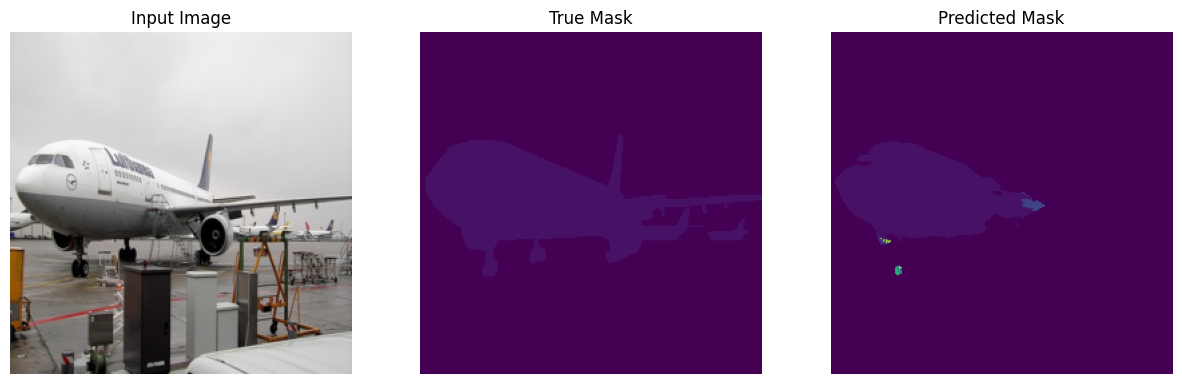

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassJaccardIndex
from tqdm import tqdm

EPOCHS = 200
LEARNING_RATE = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
iou_metric = MulticlassJaccardIndex(num_classes=N_CLASSES).to(DEVICE)
best_iou = -1.0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    model.eval()
    iou_metric.reset()
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            preds = torch.argmax(model(images), dim=1)
            iou_metric.update(preds, masks)
    val_iou = iou_metric.compute()
    
    print(f"Epoch {epoch+1} Summary: Avg Train Loss: {train_loss / len(train_loader):.4f} | Validation Mean IoU: {val_iou:.4f}")
    scheduler.step(val_iou)
    
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), 'best_voc_unet.pth')
        print(f"New best model saved with IoU: {best_iou:.4f}")

print(f"\nTraining finished. Best validation IoU: {best_iou:.4f}")

print("\nLoading best model for visualization...")
model.load_state_dict(torch.load('best_voc_unet.pth'))

def display_prediction(image_tensor, true_mask_tensor, pred_mask_tensor):
    inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    image = inv_normalize(image_tensor).cpu().permute(1, 2, 0)
    display_list = [image, true_mask_tensor.cpu(), pred_mask_tensor.cpu()]
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    plt.figure(figsize=(15, 5))
    for i in range(len(display_list)):
        plt.subplot(1, 3, i + 1); plt.title(title[i]); plt.imshow(display_list[i], vmin=0, vmax=20); plt.axis('off')
    plt.show()

model.eval()
with torch.no_grad():
    images, masks = next(iter(val_loader))
    image_sample, true_mask_sample = images[0].unsqueeze(0).to(DEVICE), masks[0]
    pred_logits = model(image_sample)
    pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0)
    display_prediction(images[0], true_mask_sample, pred_mask)

Loading model architecture from model.py...
Loading trained weights from 'best_voc_unet.pth'...
Model loaded successfully.
Generating visualization for a batch of 4 images...

Visualization saved to 'voc_prediction_visualization.png'


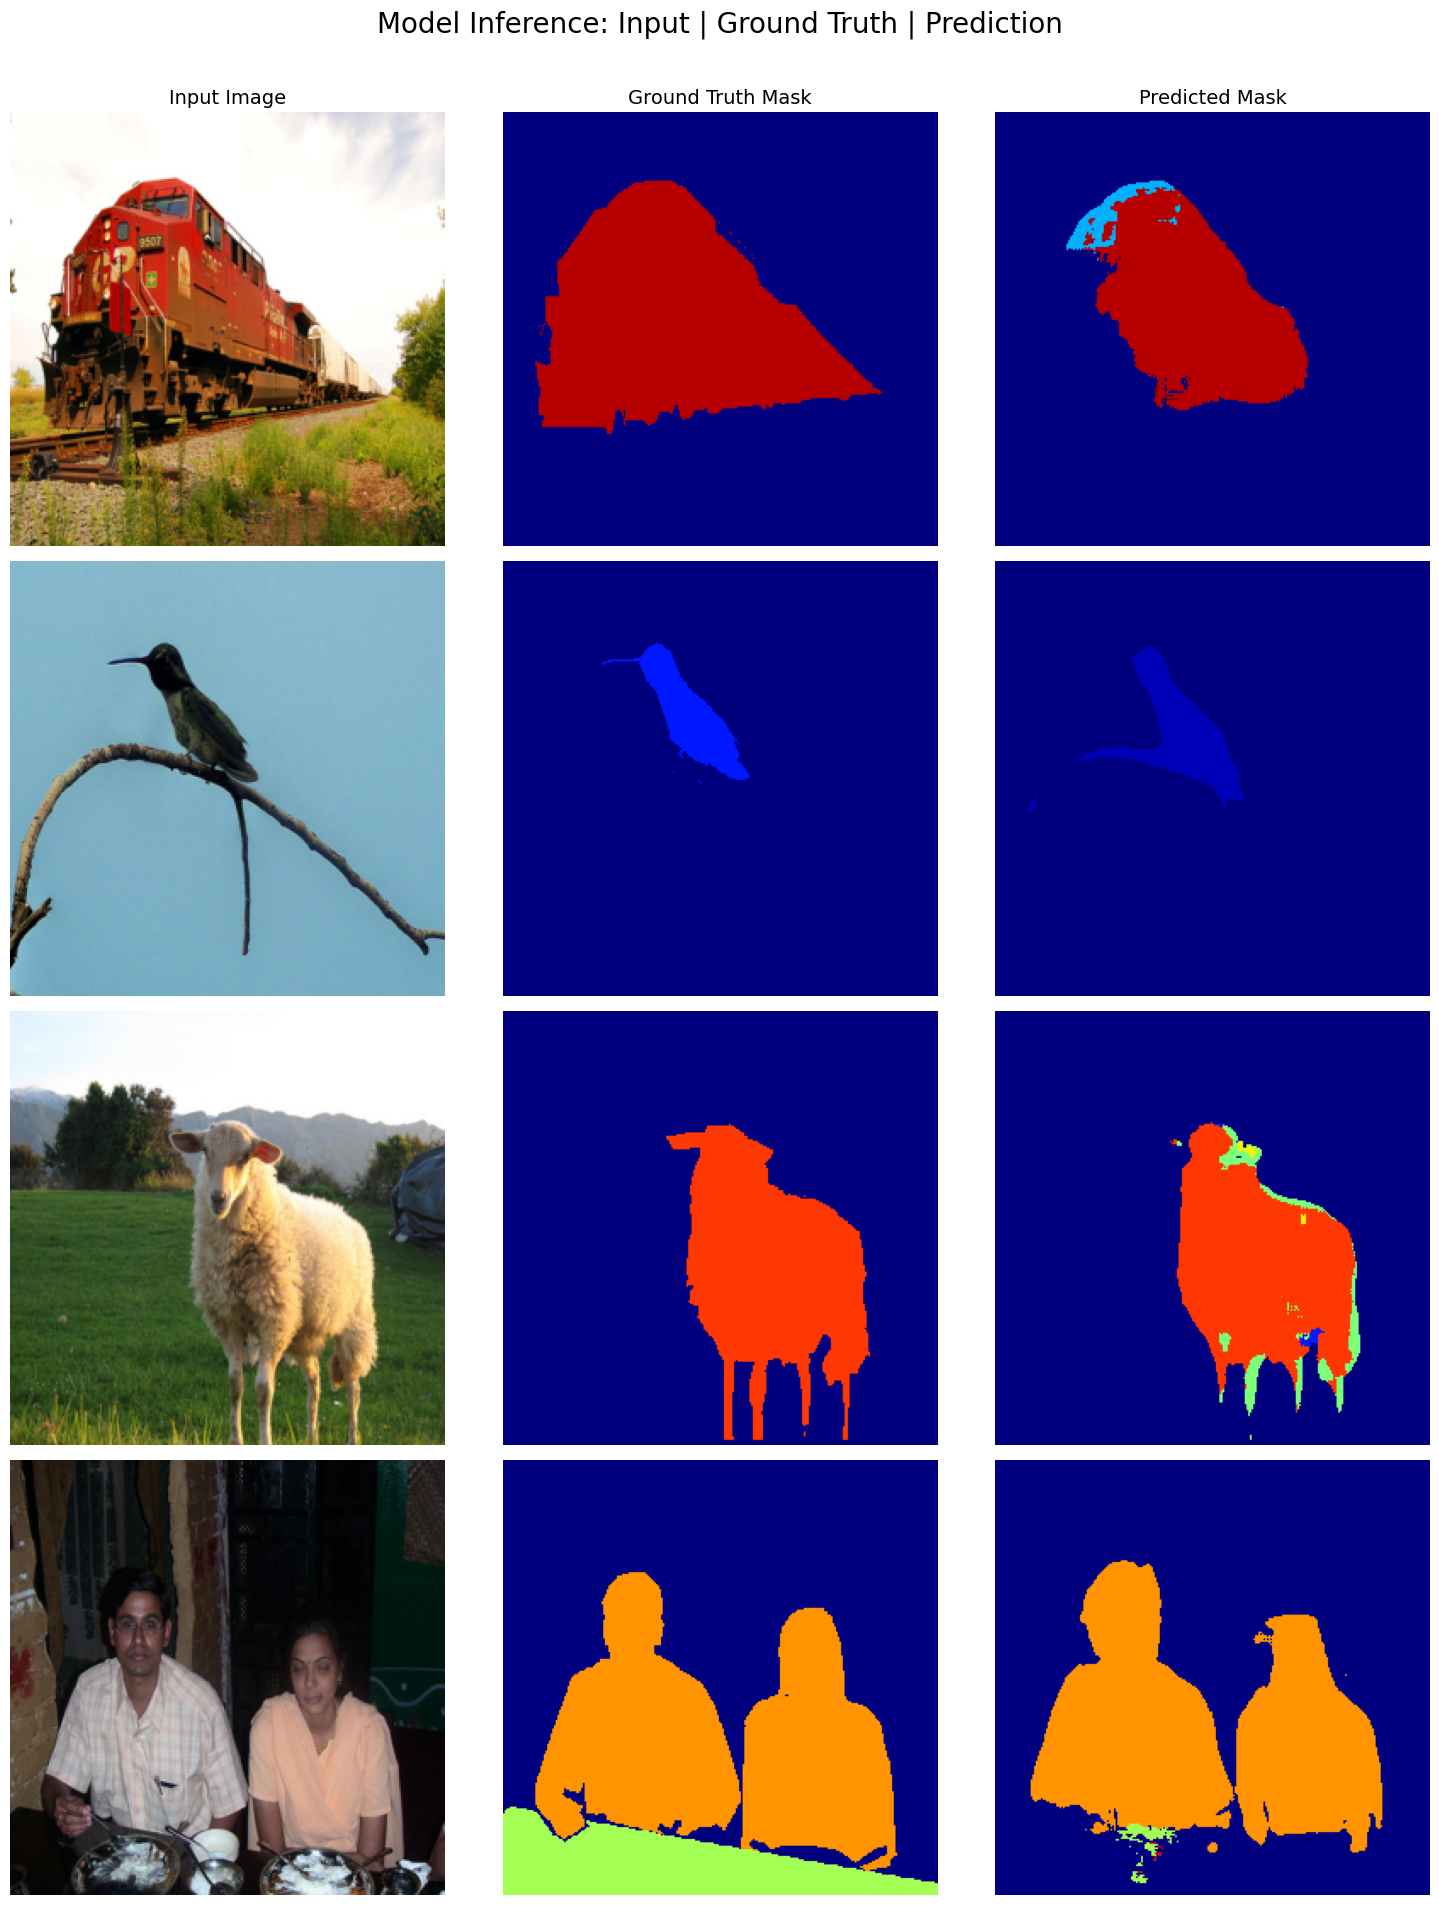

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import UNet
from dataset import VOCDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_PATH = "best_voc_unet.pth"
N_CLASSES = 21

DATA_DIR = 'VOCdevkit/VOC2012/'
IMAGE_DIR = os.path.join(DATA_DIR, 'JPEGImages')
MASK_DIR = os.path.join(DATA_DIR, 'SegmentationClass')
VAL_SPLIT_FILE = os.path.join(DATA_DIR, 'ImageSets', 'Segmentation', 'val.txt')

def main():
    print(f"Loading model architecture from model.py...")
    model = UNet(in_channels=3, num_classes=N_CLASSES).to(DEVICE)
    
    print(f"Loading trained weights from '{CHECKPOINT_PATH}'...")
    model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=True))
    print("Model loaded successfully.")

    val_ds = VOCDataset(
        image_dir=IMAGE_DIR,
        mask_dir=MASK_DIR,
        split_file=VAL_SPLIT_FILE,
    )

    val_loader = DataLoader(val_ds, batch_size=4, shuffle=True)

    model.eval()
    print("Generating visualization for a batch of 4 images...")
    
    with torch.no_grad():
        images, true_masks = next(iter(val_loader))
        images = images.to(DEVICE)
        
        pred_logits = model(images)
        pred_masks = torch.argmax(pred_logits, dim=1)

    images_cpu = images.cpu()
    true_masks_cpu = true_masks.cpu()
    pred_masks_cpu = pred_masks.cpu()

    visualize_and_save(images_cpu, true_masks_cpu, pred_masks_cpu)


def visualize_and_save(images, true_masks, pred_masks):
    inv_normalize = torchvision.transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle('Model Inference: Input | Ground Truth | Prediction', fontsize=20)
    
    titles = ['Input Image', 'Ground Truth Mask', 'Predicted Mask']
    for i in range(4):
        img_to_show = inv_normalize(images[i]).permute(1, 2, 0)
        axes[i, 0].imshow(img_to_show)
        axes[i, 0].set_title(titles[0] if i == 0 else "", fontsize=14)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_masks[i], cmap='jet', vmin=0, vmax=N_CLASSES-1)
        axes[i, 1].set_title(titles[1] if i == 0 else "", fontsize=14)
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_masks[i], cmap='jet', vmin=0, vmax=N_CLASSES-1)
        axes[i, 2].set_title(titles[2] if i == 0 else "", fontsize=14)
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    output_filename = "voc_prediction_visualization.png"
    plt.savefig(output_filename)
    print(f"\nVisualization saved to '{output_filename}'")
    
    plt.show()


if __name__ == "__main__":
    import os
    main()